In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

### EDA

In [3]:
df = pd.read_csv('./../../eda/data/merged_data.csv')

In [4]:
df = df.drop(['폐업_점포_수', '폐업_영업_개월_평균', '서울시_폐업_영업_개월_평균', '기준_년분기_코드'], axis=1)

In [5]:
# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder

cols = ['자치구_코드_명', '서비스_업종_코드_명', '상권_변화_지표']

for col in cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    print(encoder.classes_)

['강남구' '강동구' '강북구' '강서구' '관악구' '광진구' '구로구' '금천구' '노원구' '도봉구' '동대문구' '동작구'
 '마포구' '서대문구' '서초구' '성동구' '성북구' '송파구' '양천구' '영등포구' '용산구' '은평구' '종로구' '중구'
 '중랑구']
['PC방' '가구' '가방' '가전제품' '가전제품수리' '고시원' '골프연습장' '네일숍' '노래방' '당구장' '문구'
 '미곡판매' '미용실' '반찬가게' '부동산중개업' '분식전문점' '서적' '섬유제품' '세탁소' '수산물판매' '슈퍼마켓'
 '스포츠 강습' '스포츠클럽' '시계및귀금속' '신발' '안경' '애완동물' '양식음식점' '여관' '예술학원' '완구'
 '외국어학원' '운동/경기용품' '육류판매' '의료기기' '의약품' '인테리어' '일반교습학원' '일반의류' '일반의원'
 '일식음식점' '자동차미용' '자동차수리' '자전거 및 기타운송장비' '전자상거래업' '제과점' '조명용품' '중식음식점'
 '철물점' '청과상' '치과의원' '치킨전문점' '커피-음료' '컴퓨터및주변장치판매' '패스트푸드점' '편의점' '피부관리실'
 '한식음식점' '한의원' '핸드폰' '호프-간이주점' '화장품' '화초']
['HH' 'HL' 'LH' 'LL']


In [6]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 전체 데이터의 75%을 기준으로 등급 나누기
df['폐업률_등급'] = pd.qcut(df['폐업_률'], q=[0, 0.75, 1.0], labels=[0, 1])

X = df.drop(['폐업_률', '폐업률_등급'], axis=1) 
y_class = df['폐업률_등급']

smote = SMOTE(random_state=42)
X_resample, y_resample = smote.fit_resample(X, y_class)

X_train, X_test, y_train, y_test = train_test_split(
    X_resample, y_resample, test_size=0.2, random_state=42, stratify=y_resample
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\Playdata\AppData\Local\anaconda3\envs\ml_env\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\Users\Playdata\AppData\Local\anaconda3\envs\ml_env\Lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\Playdata\AppData\Local\anaconda3\envs\ml_env\Lib\threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Playdata\AppData\Local\anaconda3\envs\ml_env\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 4: invalid start byte


((48244, 132), (12062, 132), (48244,), (12062,))

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import optuna

# 목적 함수 생성
def xgb_optuna_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
    }
    xgb_clf = XGBClassifier(**params)
    
    return cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3).mean()

# 스터디 생성
study = optuna.create_study(direction='maximize')

[I 2025-10-13 21:37:43,646] A new study created in memory with name: no-name-eafffe25-daec-4391-ac2f-52b7d3bd17bd


In [10]:
study.optimize(xgb_optuna_objective, n_trials=50)

print(study.best_value)
print(study.best_params)

C:\Users\tndl3\AppData\Local\Temp\ipykernel_27420\1179490313.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 100, 500, 100),
[I 2025-10-13 21:38:24,447] Trial 0 finished with value: 0.8698905918869048 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.0650828879453693, 'colsample_bytree': 0.8740136506859832}. Best is trial 0 with value: 0.8698905918869048.
C:\Users\tndl3\AppData\Local\Temp\ipykernel_27420\1179490313.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as k

0.8761089508097792
{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.130161824676016, 'colsample_bytree': 0.7615338373458207}


In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# XGBoost 이진 분류 학습
xgb_clf = XGBClassifier(
    n_estimators = 500, 
    max_depth = 10, 
    learning_rate = 0.130161824676016,
    colsample_bytree = 0.7615338373458207
)

s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_accuracy = []

for train_index, val_index in s_kfold.split(X_train, y_train):
    X_tra, y_tra = X_train.to_numpy()[train_index], y_train.to_numpy()[train_index]
    X_val, y_val = X_train.to_numpy()[val_index], y_train.to_numpy()[val_index]


    print(np.unique(y_tra, return_counts=True))
    print(np.unique(y_val, return_counts=True))
    print('=========================================')

    # 모델 학습 > 예측 > 평가
    xgb_clf.fit(X_tra, y_tra)
    y_pred = xgb_clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    cv_accuracy.append(acc)

print('훈련별 정확도: ', cv_accuracy)
print('분류 모델 정확도: ', np.mean(cv_accuracy))

(array([0, 1]), array([19297, 19298]))
(array([0, 1]), array([4825, 4824]))
(array([0, 1]), array([19297, 19298]))
(array([0, 1]), array([4825, 4824]))
(array([0, 1]), array([19298, 19297]))
(array([0, 1]), array([4824, 4825]))
(array([0, 1]), array([19298, 19297]))
(array([0, 1]), array([4824, 4825]))
(array([0, 1]), array([19298, 19298]))
(array([0, 1]), array([4824, 4824]))
훈련별 정확도:  [0.881334853352679, 0.8759456938542854, 0.8793657373821121, 0.8751165923929941, 0.878731343283582]
분류 모델 정확도:  0.8780988440531304


---
### test 데이터 예측 -> 평가

In [8]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report

y_pred = xgb_clf.predict(X_test)

print(f'정확도: {accuracy_score(y_test, y_pred)}, 정밀도: {precision_score(y_test, y_pred)}, 재현율: {recall_score(y_test, y_pred)}, f1: {f1_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=['안정', '위험']))

정확도: 0.8787929033327806, 정밀도: 0.8863521055301877, 재현율: 0.8690101144088874, f1: 0.8775954454119224
              precision    recall  f1-score   support

          안정       0.87      0.89      0.88      6031
          위험       0.89      0.87      0.88      6031

    accuracy                           0.88     12062
   macro avg       0.88      0.88      0.88     12062
weighted avg       0.88      0.88      0.88     12062



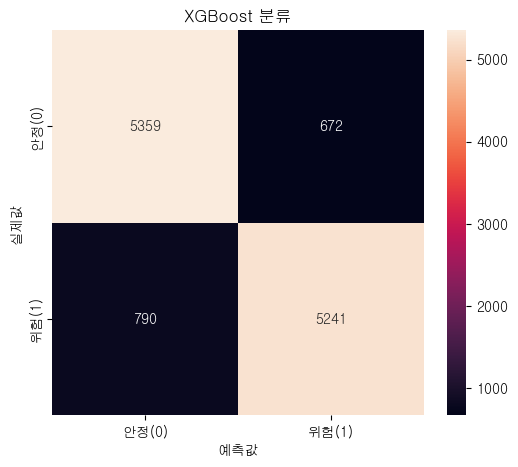

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['안정(0)', '위험(1)'],
            yticklabels=['안정(0)', '위험(1)'])

plt.xlabel('예측값')
plt.ylabel('실제값')
plt.title('XGBoost 분류')
plt.show()

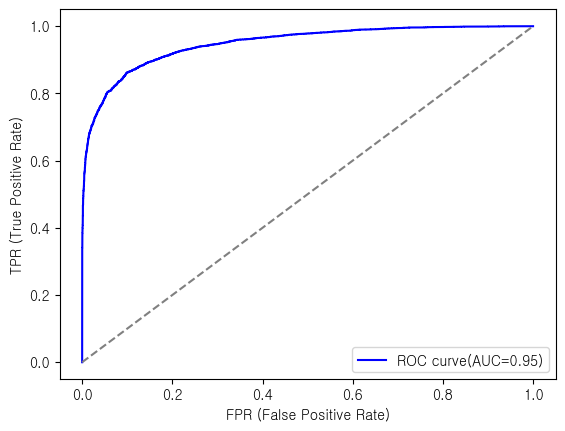

In [10]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve(AUC={roc_auc:.2f})')
plt.plot([0, 1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.legend()
plt.show()

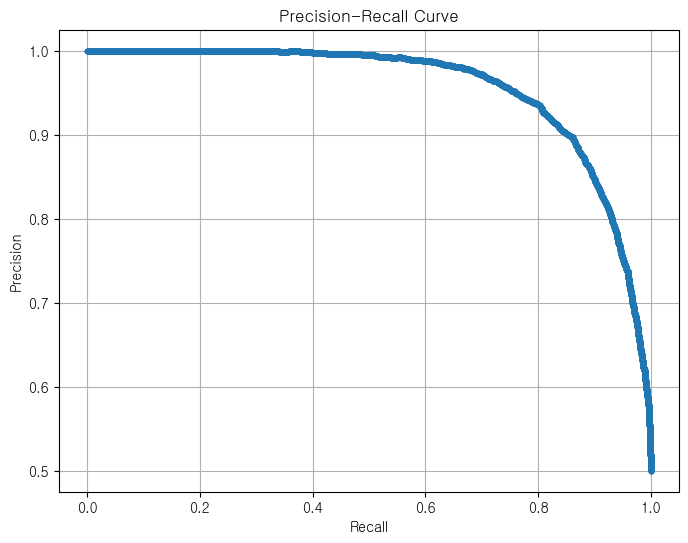

In [16]:
# PR Curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_6184\3460952017.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances_df.head(20), x='Importance', y='Feature', palette='viridis')


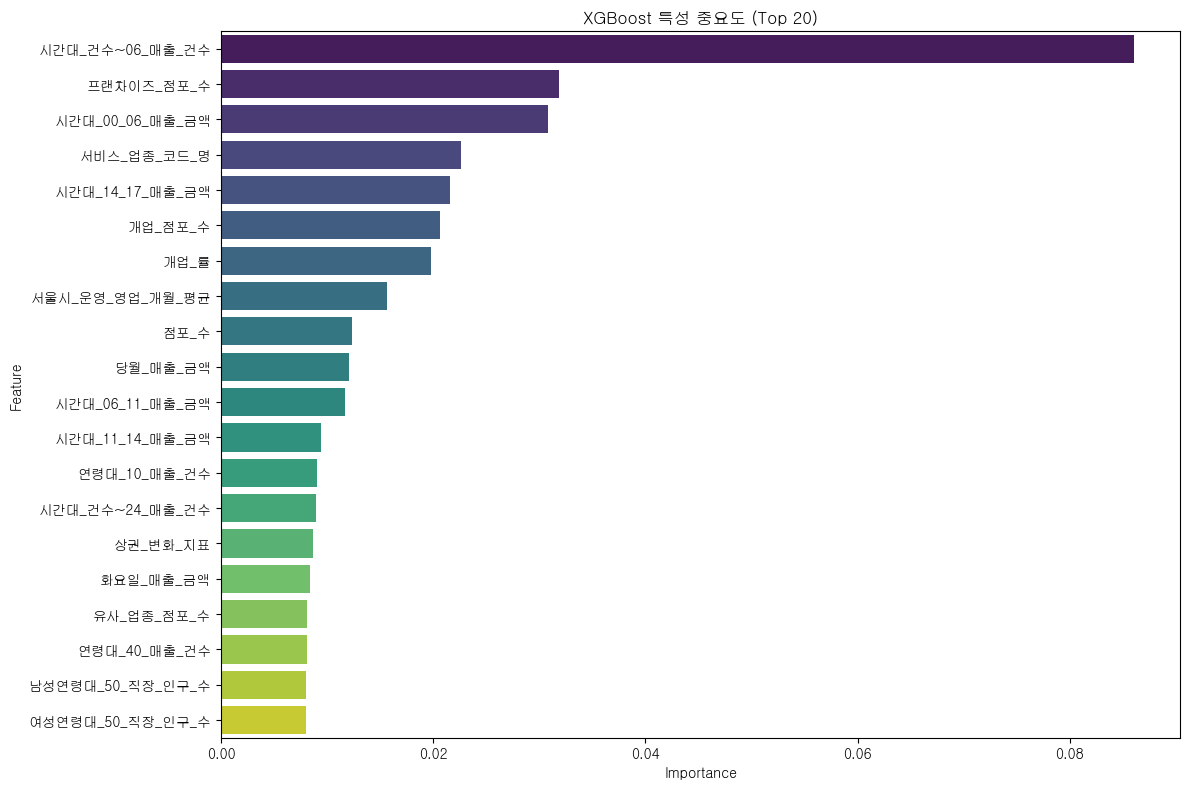

In [17]:
# 특성 중요도 시각화
feature_importances = xgb_clf.feature_importances_
feature_names = X_train.columns

# 데이터프레임으로 정리
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 상위 20개 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=importances_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost 특성 중요도 (Top 20)')
plt.tight_layout()
plt.show()